In [36]:
import json
import pandas as pd 
import glob 
import os 
import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [19]:
def read_json(filename):
    with open(filename, 'r') as file: 
        return json.load(file)

In [20]:
files = glob.glob('jsons/*')

In [21]:
def return_all_keys(adict, key_suff=''): 
    all_keys = []
    for key, value in adict.items():
        if isinstance(value, dict): 
            all_keys += return_all_keys(value, key_suff=f'{key}->')
        all_keys.append(key_suff + key)
    return all_keys


In [22]:
whole_data = []
for file in tqdm.tqdm(files):
    data = read_json(file)
    if 'code' in data and data['code'] == 400000:
        continue
    if 'list' in data: 
        rows = pd.json_normalize(data['list'])
        rows['lat'], rows['lng'] = os.path.basename(file).replace('.json', '').split('_')
        whole_data.append(rows)
whole_data = pd.concat(whole_data)

100%|███████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 398.88it/s]


In [23]:
whole_data = whole_data.drop(['weather', 'wind.gust', 'main.feels_like', 'main.temp_min','main.temp_max'], axis=1)

In [24]:
whole_data.count()

dt               25670
main.temp        25670
main.pressure    25670
main.humidity    25670
wind.speed       25670
wind.deg         25670
clouds.all       25670
snow.1h           1407
lat              25670
lng              25670
rain.1h            938
dtype: int64

In [25]:
whole_data = whole_data.fillna(0)

In [26]:
whole_data = whole_data.rename({'dt': 'time_unix'}, axis=1)

In [27]:
whole_data['lat'] = whole_data['lat'].apply(float)
whole_data['lng'] = whole_data['lng'].apply(float)

In [28]:
air = pd.read_feather('air_data.feather')

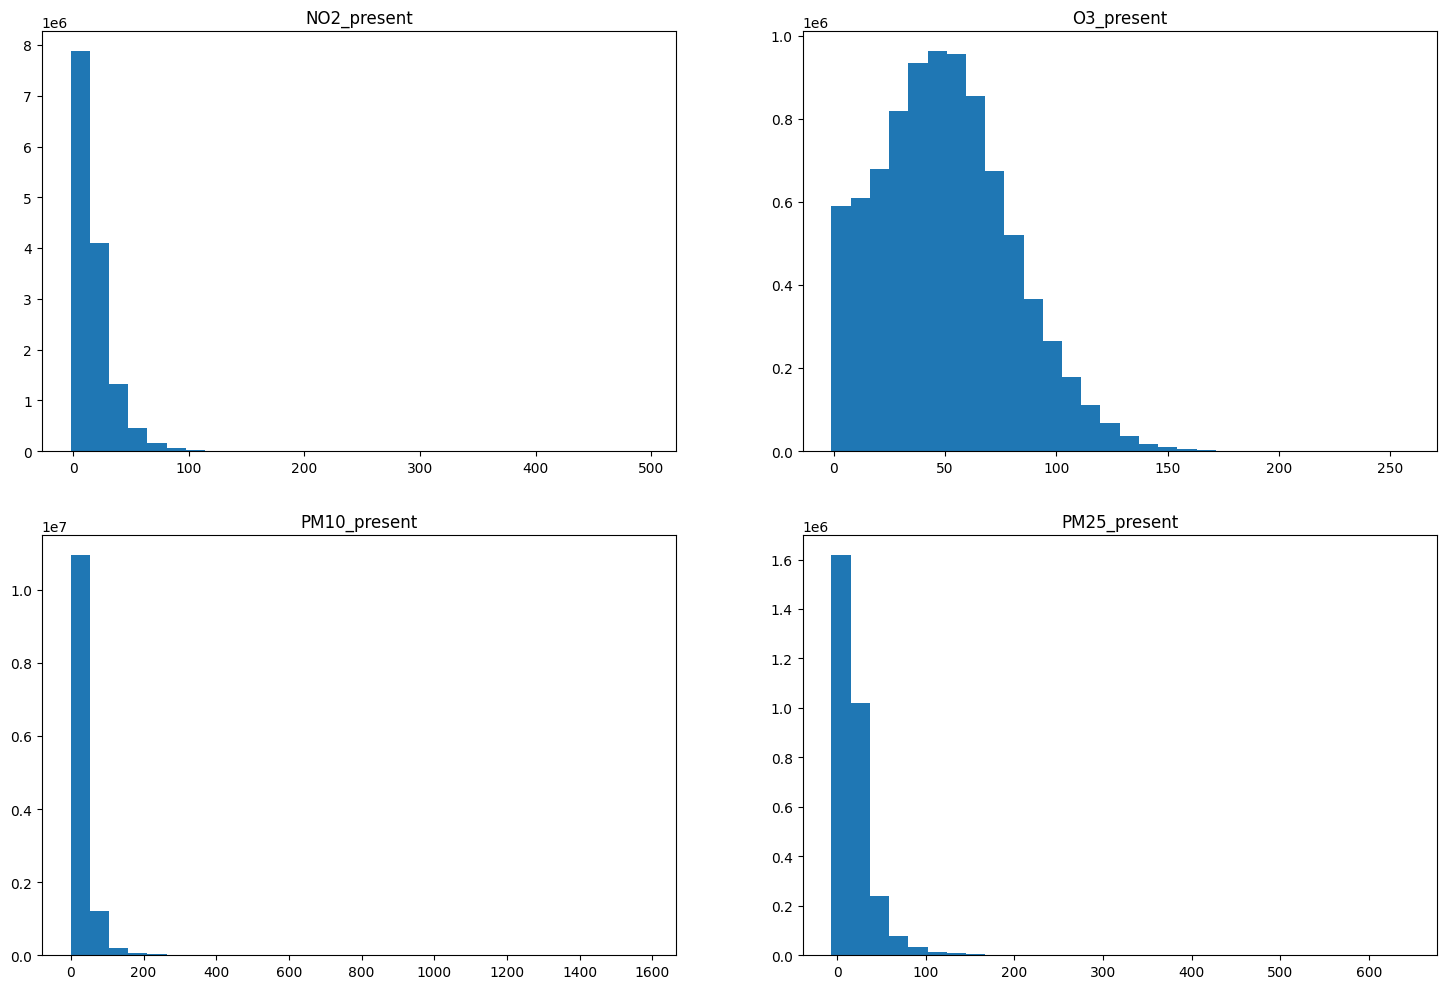

In [34]:
cols = ['NO2_present','O3_present','PM10_present','PM25_present']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9*2, 6*2))
axs = axs.flatten()
for i, col in enumerate(cols):
    axs[i].hist(air[col], bins=30)
    axs[i].set_title(col)
    

In [12]:
data = air.merge(whole_data)

In [13]:
data['time'] = pd.to_datetime(data['time_unix'],unit='s')

In [14]:
data['month'] = data['time'].apply(lambda x: x.month)
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekday'] = data['time'].apply(lambda x: x.weekday())

In [15]:
data = data.drop(['time', 'time_unix_plus_1h', 'lat', 'lng', 'time_unix'], axis=1)

In [16]:
data = data.rename({col: col.replace('.', '_') for col in data.columns}, axis=1)

In [17]:
data.to_csv('complete_data.csv', index=False)